# Plotting of DMS and Chlorophyll-A for CMAQ

---
    author: Barron H. Henderson
    date: 2021-03-23
    last updated: 2022-04-29
    contributors: Brett Gantt, Jeff Willison, and Golam Sarwar
---

This notebook creates figures from DMS and CHLO files and the inputs used to create them. The inputs are often only viewed to diagnose unexpected results.



# Specify User Input Options

* User input options are described below.
* Most users will update `dom`

In [1]:
# dom : str
#     Name of output domain. For example, 12US1, 36US3, 108NHEMI2. This is used
#     to name outputs and inputs.
dom = '12US1'

In [2]:
dmsoutpath = f'dmsclimatology/{dom}/dmsconcentration.{dom}.nc'
chlotmpl = f'chlor_a/{dom}/A*.nc'
ocnouttmpl = f'output/{dom}/OCEAN_*_L3m*.nc'

# Import libraries


In [3]:
%matplotlib inline
import os
from copy import copy
from glob import glob
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import pycno
import PseudoNetCDF as pnc

os.environ['IOAPI_ISPH'] = '6370000.'
warnings.simplefilter('ignore')

In [4]:
ocnoutpaths = sorted(glob(ocnouttmpl))

In [5]:
gdpath = ocnoutpaths[0]
gdf = pnc.pncopen(gdpath, format='ioapi')
gproj = gdf.getproj(withgrid=True)
gcno = pycno.cno(proj=gproj)
cno = pycno.cno()


In [6]:
cmap = copy(plt.get_cmap('viridis'))
cmap.set_under('grey')
chlonorm = plt.Normalize(vmin=1e-6, vmax=4)
dmsnorm = plt.Normalize(vmin=1e-6, vmax=8)

# Visualize DMS and CHLO in CMAQ-ready File


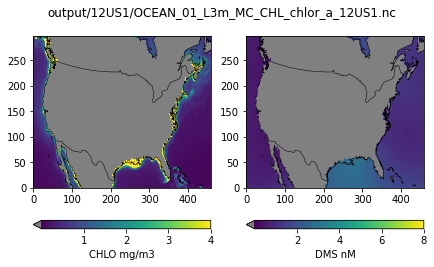

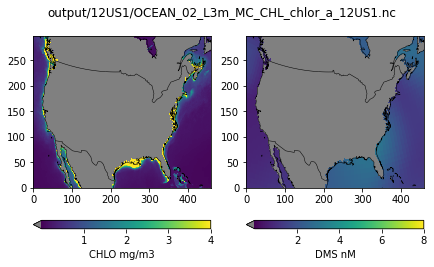

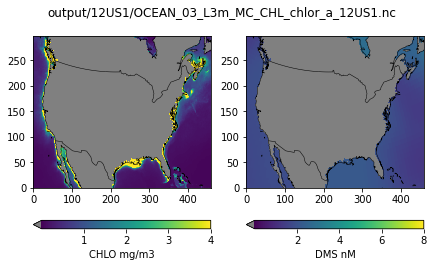

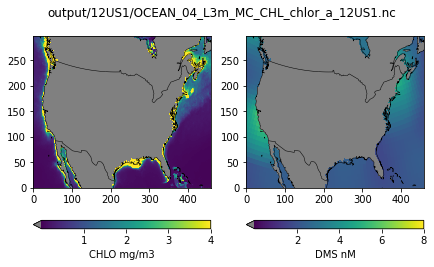

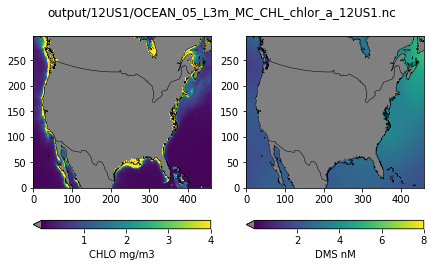

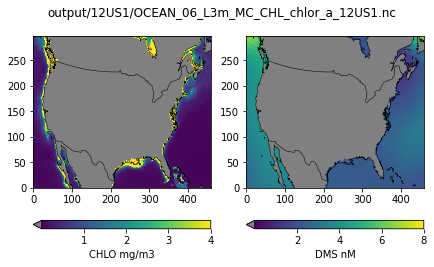

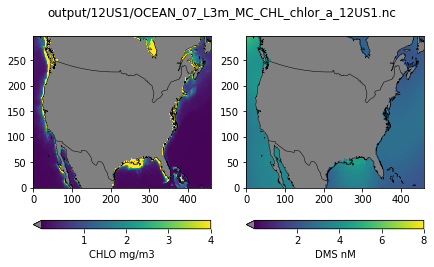

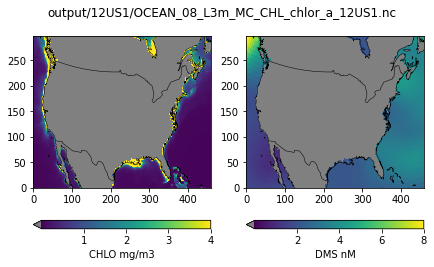

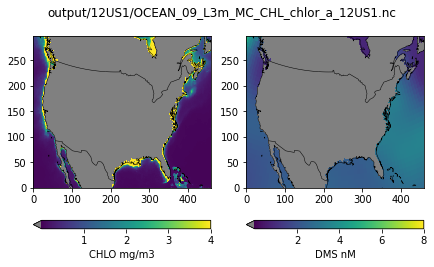

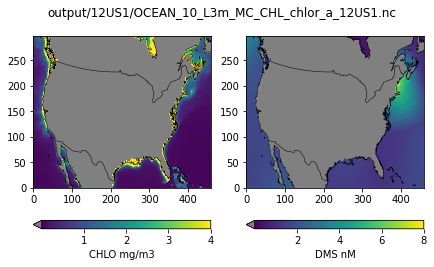

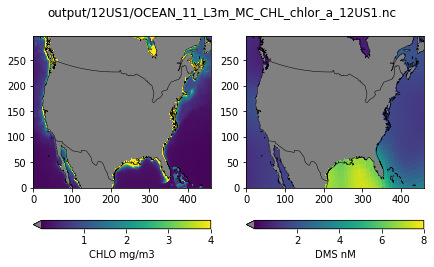

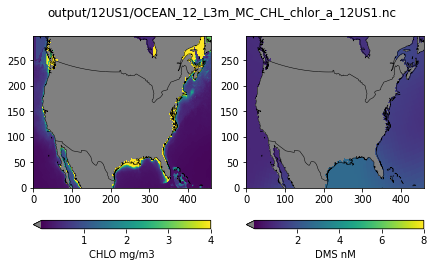

In [7]:
for ocnoutpath in ocnoutpaths:
    ocnf = pnc.pncopen(ocnoutpath, format='ioapi')
    fig, axx = plt.subplots(1, 2, figsize=(7, 4))
    p = axx[0].pcolormesh(ocnf.variables['CHLO'][0, 0], norm=chlonorm, cmap=cmap)
    fig.colorbar(p, orientation='horizontal', ax=axx[0], label='CHLO mg/m3', extend='min');
    p = axx[1].pcolormesh(ocnf.variables['DMS'][0, 0], norm=dmsnorm, cmap=cmap)
    fig.colorbar(p, orientation='horizontal', ax=axx[1], label='DMS nM', extend='min');
    fig.suptitle(ocnoutpath)
    for ax in axx.ravel():
        gcno.draw(ax=ax)


# DMS Processing Vizualization

* Vizualize lat/lon DMS
* Vizualize the gridded DMS

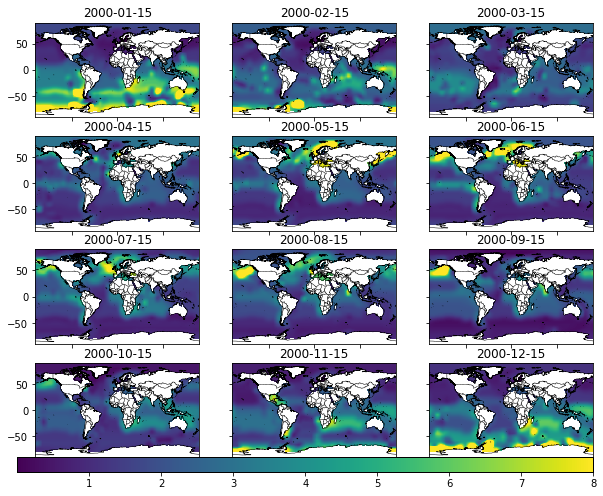

In [8]:
dmsfile = pnc.pncopen('dmsclimatology/dmsconcentration.nc', format='netcdf')
times = dmsfile.getTimes()
lon = dmsfile.variables['longitude'][:]
lat = dmsfile.variables['latitude'][:]
dmsvar = dmsfile.variables['DMS']
fig, axx = plt.subplots(4, 3, figsize=(10, 8), sharex=True, sharey=True)
cax = fig.add_axes([.1, .1, .8, .025])
for ai, ax in enumerate(axx.ravel()):
    p = ax.pcolormesh(lon, lat, dmsvar[ai], norm=dmsnorm, shading='nearest')
    fig.colorbar(p, cax=cax, orientation='horizontal')
    ax.set_title(times[ai].strftime('%Y-%m-%d'))
    cno.draw(ax=ax)


# Visualize Interpolated DMS Concentrations

* Overland portions of the domain are masked before making files CMAQ-ready.

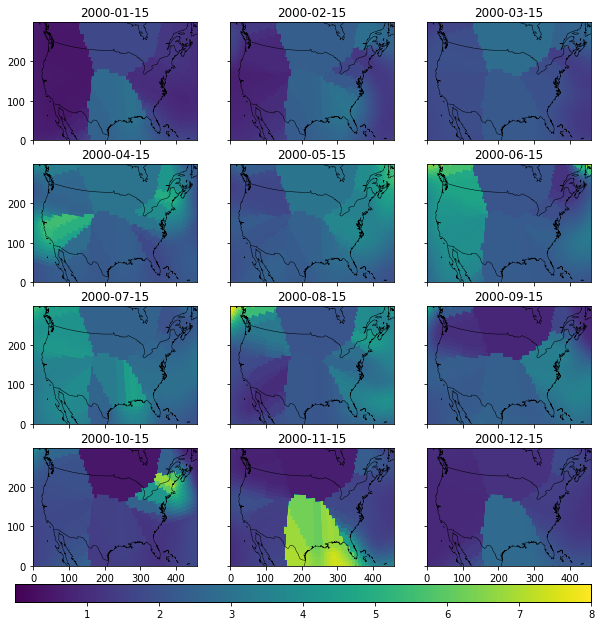

In [9]:
dmsdomfile = pnc.pncopen(dmsoutpath, format='netcdf')
dmsvar = dmsdomfile.variables['DMS']
times = dmsdomfile.getTimes()
fig, axx = plt.subplots(4, 3, figsize=(10, 10), sharex=True, sharey=True)
cax = fig.add_axes([.1, .075, .8, .025])
lnorm = plt.matplotlib.colors.LogNorm(vmin=1, vmax=50)

for ai, ax in enumerate(axx.ravel()):
    p = ax.pcolormesh(dmsvar[ai], norm=dmsnorm)
    fig.colorbar(p, cax=cax, orientation='horizontal',)
    ax.set_title(times[ai].strftime('%Y-%m-%d'))
    gcno.draw(ax=ax)

# Chlor-A Processing Vizualization

* Vizualize lat/lon Chlor-A
* Vizualize the interpolated gridded Chlor-A

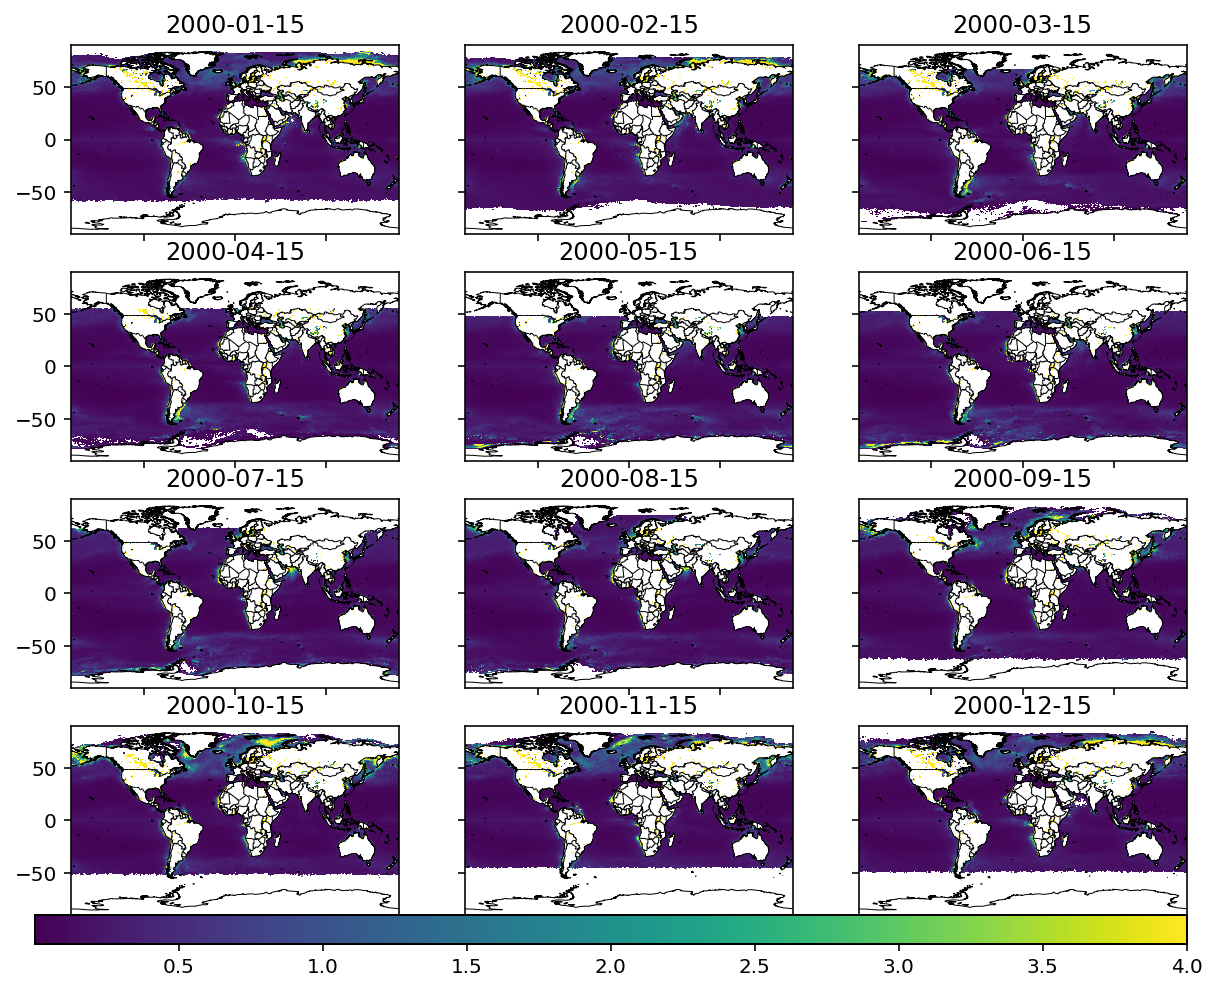

In [10]:
chlinpaths = sorted(glob('chlor_a/A*.nc'))
chlorfs = [pnc.pncopen(tmppath).insertDimension(time=1, before='lat', multionly=True) for tmppath in  chlinpaths]
chlorf = chlorfs[0].stack(chlorfs[1:], 'time')
lat = chlorf.variables['lat']
lon = chlorf.variables['lon']
chlorvar = chlorf.variables['chlor_a']

fig, axx = plt.subplots(4, 3, figsize=(10, 8), sharex=True, sharey=True, dpi=144)
cax = fig.add_axes([.1, .1, .8, .025])
nthin = 1

lnorm = plt.matplotlib.colors.LogNorm()
for ai, ax in enumerate(axx.ravel()):
    p = ax.pcolormesh(
        lon[::nthin], lat[::nthin], chlorvar[ai, ::nthin, ::nthin],
        norm=chlonorm, shading='nearest'
    )
    fig.colorbar(p, cax=cax, orientation='horizontal')
    ax.set_title(times[ai].strftime('%Y-%m-%d'))
    cno.draw(ax=ax)


* Note: that overland concentrations will be masked in the CMAQ-ready files.

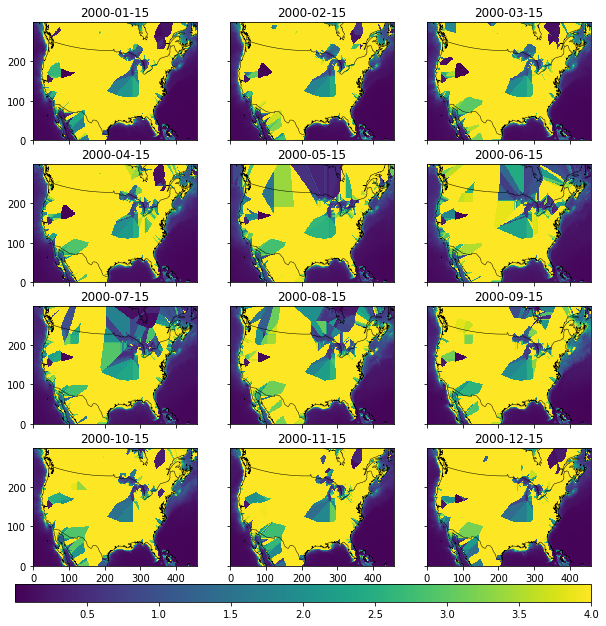

In [11]:
chlornewgridpaths = sorted(glob(chlotmpl))
chlordomfs = [pnc.pncopen(tmppath).insertDimension(TSTEP=1, before='ROW', multionly=True) for tmppath in  chlornewgridpaths]
chlordomf = chlordomfs[0].stack(chlordomfs[1:], 'TSTEP')
chlorvar = chlordomf.variables['chlor_a']

fig, axx = plt.subplots(4, 3, figsize=(10, 10), sharex=True, sharey=True)
cax = fig.add_axes([.1, .075, .8, .025])

for ai, ax in enumerate(axx.ravel()):
    p = ax.pcolormesh(chlorvar[ai], norm=chlonorm)
    ax.set_title(times[ai].strftime('%Y-%m-%d'))
    gcno.draw(ax=ax)
    
fig.colorbar(p, cax=cax, orientation='horizontal')